In [2]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import re
import pickle

import octis
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.models.CTM import CTM
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

d:\MHA\Topic Modeling Project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
dataset = Dataset()
dataset.load_custom_dataset_from_folder("content/corpus")

In [11]:
import inspect
print(inspect.getsource(octis.optimization.optimizer.Optimizer))

class Optimizer:
    """
    Class Optimizer to perform Bayesian Optimization on Topic Model
    """

    def optimize(
        self, model, dataset, metric, search_space, extra_metrics=None,
        number_of_call=5, n_random_starts=1,
        initial_point_generator="lhs",  # work only for version skopt 8.0!!!
        optimization_type='Maximize', model_runs=5, surrogate_model="RF",
        kernel=1.0 * Matern(
            length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5),
        acq_func="LCB", random_state=False, x0=None, y0=None,
        save_models=True, save_step=1, save_name="result",
        save_path="results/", early_stop=False, early_step=5,
        plot_best_seen=False, plot_model=False, plot_name="B0_plot",
            log_scale_plot=False, topk=10):
        """
        Perform hyper-parameter optimization for a Topic Model

        :param model: model with hyperparameters to optimize
        :type model: OCTIS Topic Model
        :param dataset: dataset for th

In [10]:
cv = Coherence(texts=dataset.get_corpus(), measure='c_v')
umass = Coherence(texts=dataset.get_corpus(), measure='u_mass')
uci = Coherence(texts=dataset.get_corpus(), measure='c_uci')
npmi = Coherence(texts=dataset.get_corpus())
topic_diversity = TopicDiversity(topk=10)

In [4]:
search_space = {
    'activation': Categorical({'sigmoid', 'relu', 'softplus','tanh', 'leakyrelu', 'rrelu', 'elu', 'selu'}),
    'dropout': Real(0.0, 0.95),
    'momentum': Real(0.0, 0.95),
    'solver': Categorical({'adam', 'sgd'}),
    'num_layers': Categorical({1, 2, 3, 4, 5}), 
    'num_neurons': Categorical({16, 32, 64, 128, 256}),
}

In [5]:
model = CTM(num_topics=7,inference_type="combined",reduce_on_plateau=True,learn_priors=True,num_epochs=50,use_partitions=False, bert_model='all-mpnet-base-v2', bert_path='content/bert_path/all-mpnet-base-v2/_allmpnet')

In [9]:
optimization_runs = 90
model_runs = 1

In [ ]:
optimizer=Optimizer()
optimization_result = optimizer.optimize(
    model=model,
    dataset=dataset,
    metric=npmi,
    search_space=search_space,
    extra_metrics=[cv, uci, topic_diversity],
    number_of_call=optimization_runs,
    model_runs=model_runs,
    initial_point_generator="lhs",
    optimization_type='Maximize',
    acq_func="LCB",
    random_state=38,
    save_models=True,
    save_path="results/model_2/",
    plot_best_seen=True, 
    plot_model=True, 
    plot_name="B0_plot",
    log_scale_plot=True, 
    topk=10
)


In [ ]:
optimizer=Optimizer()
optimization_result = optimizer.resume_optimization('results/model_2/result.json',extra_evaluations=1)

In [5]:
optimization_result.save_to_csv("results_ctm_opt.csv")

In [3]:
res = json.load(open("results/model_2/result.json",'r'))
res.keys()

dict_keys(['dataset_name', 'dataset_path', 'is_cached', 'kernel', 'acq_func', 'surrogate_model', 'optimization_type', 'model_runs', 'save_models', 'save_step', 'save_name', 'save_path', 'early_stop', 'early_step', 'plot_model', 'plot_best_seen', 'plot_name', 'log_scale_plot', 'search_space', 'model_name', 'model_attributes', 'use_partitioning', 'metric_name', 'extra_metric_names', 'metric_attributes', 'extra_metric_attributes', 'current_call', 'number_of_call', 'random_state', 'x0', 'y0', 'n_random_starts', 'initial_point_generator', 'topk', 'time_eval', 'dict_model_runs', 'f_val', 'x_iters'])

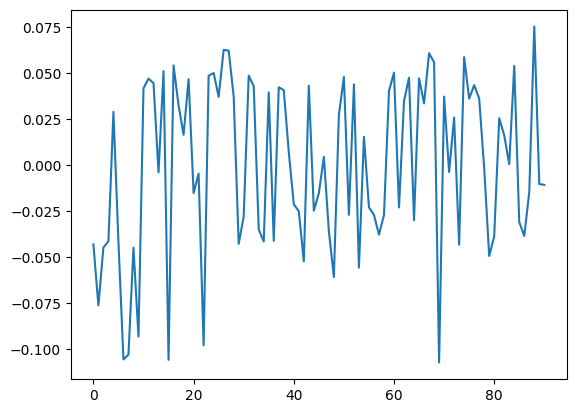

In [4]:
import matplotlib.pyplot as plt

plt.plot(res["f_val"])
plt.show()

In [5]:
import os
from octis.models.model import load_model_output

# Specify the path to the model output folder
folder_path = "results/model_2/models/"

# Create an empty dictionary to store the models
models_dict = {}

# Iterate over the files in the folder
for file_name in os.listdir(folder_path):
    # Extract the model name from the file name
    model_name = os.path.splitext(file_name)[0]

    # Construct the full path to the model file
    model_path = os.path.join(folder_path, file_name)

    # Load the model using the provided function
    loaded_model = load_model_output(model_path)

    # Add the model to the dictionary with the model name as the key
    models_dict[model_name] = loaded_model



In [11]:
# Create a new dictionary to store the metrics
model_metrics = {}

# Iterate over the models in models_dict
for model_name, model_data in models_dict.items():
    # Calculate the metrics for the current model
    x = model_data
    topic_diversity_score = topic_diversity.score(x)
    cv_score = cv.score(x)
    npmi_score = npmi.score(x)
    uci_score = uci.score(x)
    umass_score = umass.score(x)

    # Create a new dictionary to store the metric results for the current model
    metrics_data = {
        "topic_diversity": topic_diversity_score,
        "coherence_cv": cv_score,
        "coherence_uci": uci_score,
        "coherence_npmi": npmi_score,
        "coherence_umass": umass_score
    }

    # Add the metrics to the model_metrics dictionary using the model_name as the key
    model_metrics[model_name] = metrics_data

In [12]:
# Sorting the models based on coherence_cv score
sorted_models = sorted(model_metrics.items(), key=lambda x: x[1]['coherence_cv'], reverse=True)

# Printing the top 10 models
print("Top 10 models based on coherence_cv score:")
for rank, (model_name, metrics_data) in enumerate(sorted_models[:10], 1):
    coherence_cv_score = metrics_data['coherence_cv']
    print(f"{rank}. {model_name} - {coherence_cv_score}")


Top 10 models based on coherence_cv score:
1. 88_0 - 0.7091233360935479
2. 67_0 - 0.698087684370532
3. 16_0 - 0.6913582182086876
4. 68_0 - 0.6895594129373116
5. 65_0 - 0.68219204736953
6. 14_0 - 0.6810828582512952
7. 27_0 - 0.6807500930448469
8. 26_0 - 0.6802654891488376
9. 84_0 - 0.6801392091528103
10. 50_0 - 0.6794856802983886


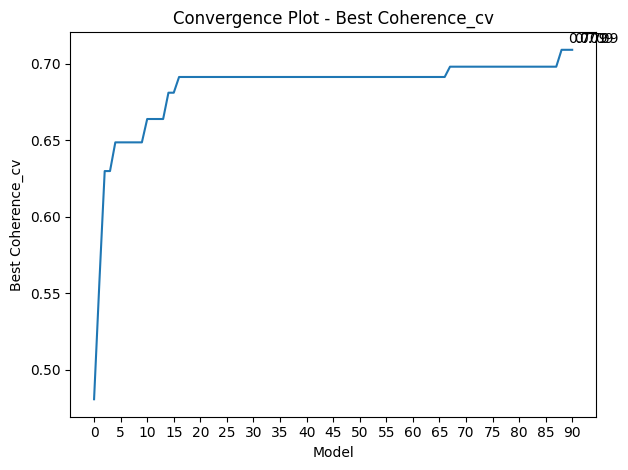

In [13]:
# Extract 'coherence_cv' values and sort them based on the model number
sorted_models = sorted(model_metrics.items(), key=lambda x: int(x[0].split('_')[0]))
models, cv_values = zip(*[(model, metrics['coherence_cv']) for model, metrics in sorted_models])

# Initialize the best_seen variable to track the highest value seen so far
best_seen = 0
best_models = []

# Iterate through the 'coherence_cv' values and keep track of the highest value seen
for model, cv_value in zip(models, cv_values):
    if cv_value > best_seen:
        best_seen = cv_value
    best_models.append((model, best_seen))

# Extract the x and y coordinates for plotting the line
best_models_x, best_models_y = zip(*[(int(model.split('_')[0]), cv) for model, cv in best_models])

# Plot the convergence line
plt.plot(best_models_x, best_models_y, linestyle='-')
plt.xlabel('Model')
plt.ylabel('Best Coherence_cv')
plt.title('Convergence Plot - Best Coherence_cv')

# Annotate points with higher CV values or blank space for lower CV values
for model, cv in best_models:
    annotation = f"{cv:.3f}" if cv == best_seen else ""  # Show value only if it's the highest value
    plt.annotate(annotation, xy=(int(model.split('_')[0]), cv), xytext=(5, 5), textcoords='offset points')

plt.xticks(list(range(0, len(best_models_x), 5)), best_models_x[::5])  # Show every 5th model
plt.tight_layout()
plt.show()

In [26]:
df = pd.DataFrame([(key, value['coherence_cv']) for key, value in model_metrics.items()],
                  columns=['Model', 'Coherence_cv'])

# Convert the "Modelcolumn to integers for sorting
df['Model'] = df['Model'].apply(lambda x: int(x.split('_')[0]))

# Sort the DataFrame based on the "Model" column in ascending order
df = df.sort_values(by='Model')

# Reset the index to get a clean order
df = df.reset_index(drop=True)

# Add a new column to indicate the max coherence_cv value seen so far
df['Max_Coherence_cv'] = df['Coherence_cv'].cummax()

,Model,Coherence_cv,Max_Coherence_cv
0,0,0.480728,0.480728
1,1,0.557288,0.557288
2,2,0.629868,0.629868
3,3,0.510624,0.629868
4,4,0.648630,0.648630
5,5,0.609384,0.648630
6,6,0.492631,0.648630
7,7,0.411010,0.648630
8,8,0.627115,0.648630
9,9,0.449143,0.648630


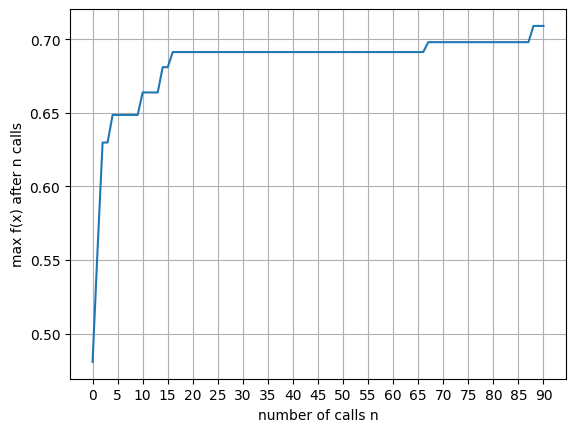

In [37]:
# Plot the line chart
plt.plot(df['Model'], df['Max_Coherence_cv'])
plt.xlabel('number of calls n')
plt.ylabel('max f(x) after n calls')
plt.grid(True)

# Show a subset of x-axis ticks to make it neat
plt.xticks(df['Model'][::5])  # Display every second tick

plt.show()

In [19]:
# Sorting the models based on coherence_npmi score
sorted_models = sorted(model_metrics.items(), key=lambda x: x[1]['coherence_npmi'], reverse=True)

# Printing the top 10 models
print("Top 10 models based on coherence_npmi score:")
for rank, (model_name, metrics_data) in enumerate(sorted_models[:10], 1):
    coherence_npmi_score = metrics_data['coherence_npmi']
    print(f"{rank}. {model_name} - {coherence_npmi_score}")


Top 10 models based on coherence_npmi score:
1. 88_0 - 0.07520695146176985
2. 26_0 - 0.06252405498911731
3. 27_0 - 0.0620892503889142
4. 67_0 - 0.06071405805336603
5. 74_0 - 0.05855525619403198
6. 68_0 - 0.05578154186754843
7. 16_0 - 0.05408481216197305
8. 84_0 - 0.05379110056078128
9. 14_0 - 0.05099343784181765
10. 60_0 - 0.05015333947800503


In [20]:
# Sorting the models based on coherence_uci score
sorted_models = sorted(model_metrics.items(), key=lambda x: x[1]['coherence_uci'], reverse=True)

# Printing the top 10 models
print("Top 10 models based on coherence_uci score:")
for rank, (model_name, metrics_data) in enumerate(sorted_models[:10], 1):
    coherence_uci_score = metrics_data['coherence_uci']
    print(f"{rank}. {model_name} - {coherence_uci_score}")


Top 10 models based on coherence_uci score:
1. 88_0 - -0.6407753532641273
2. 74_0 - -0.7752317778466068
3. 26_0 - -0.7862337388015695
4. 27_0 - -0.8026456608180054
5. 84_0 - -0.8247989853342211
6. 16_0 - -0.845839002416749
7. 67_0 - -0.8767191577164688
8. 37_0 - -0.8841843858235421
9. 14_0 - -0.8996848386549371
10. 68_0 - -0.9057943074763971


In [23]:
topic_diversity_score = topic_diversity.score(models_dict['88_0'])
cv_score = cv.score(models_dict['88_0'])
npmi_score = npmi.score(models_dict['88_0'])
uci_score = uci.score(models_dict['88_0'])

print(f"topic diversity: {topic_diversity_score}")
print(f"coherence CV: {cv_score}")
print(f"coherence NPMI: {npmi_score}")
print(f"coherence UCI: {uci_score}")

topic diversity: 1.0
coherence CV: 0.7091233360935479
coherence NPMI: 0.07520695146176985
coherence UCI: -0.6407753532641273


In [24]:
topic_diversity_score = topic_diversity.score(models_dict['26_0'])
cv_score = cv.score(models_dict['26_0'])
npmi_score = npmi.score(models_dict['26_0'])
uci_score = uci.score(models_dict['26_0'])

print(f"topic diversity: {topic_diversity_score}")
print(f"coherence CV: {cv_score}")
print(f"coherence NPMI: {npmi_score}")
print(f"coherence UCI: {uci_score}")

topic diversity: 1.0
coherence CV: 0.6802654891488376
coherence NPMI: 0.06252405498911731
coherence UCI: -0.7862337388015695


In [25]:
best_model1 = models_dict['88_0']
best_model1['topics']

array([['listen', 'song', 'music', 'spotify', 'playlist', 'premium',
        'shuffle', 'podcast', 'new', 'home'],
       ['work', 'reinstall', 'open', 'cache', 'phone', 'uninstall',
        'restart', 'crash', 'clear', 'fine'],
       ['cash', 'card', 'account', 'support', 'customer', 'money',
        'email', 'help', 'cashapp', 'bank'],
       ['game', 'roblox', 'fun', 'really', 'amazing', 'good', 'lot',
        'love', 'great', 'overall'],
       ['pure', 'dump', 'meh', 'unnecessarily', 'aside', 'endlessly',
        'scratch', 'excessively', 'disrupt', 'counter'],
       ['video', 'post', 'comment', 'reel', 'watch', 'second', 'ad',
        'short', 'click', 'upload'],
       ['ai', 'snapchat', 'split', 'chat', 'feature', 'group', 'remove',
        'option', 'pin', 'top']], dtype='<U13')

In [26]:
best_model2 = models_dict['26_0']
best_model2['topics']

array([['ai', 'feature', 'snapchat', 'split', 'top', 'user', 'option',
        'chat', 'remove', 'pin'],
       ['rn', 'clicking', 'slider', 'processing', 'quiet', 'hot', 'grid',
        'fit', 'vs', 'upsetting'],
       ['post', 'photo', 'notification', 'reel', 'picture', 'comment',
        'save', 'story', 'message', 'see'],
       ['reinstall', 'cache', 'work', 'crash', 'download', 'restart',
        'phone', 'uninstall', 'connection', 'clear'],
       ['game', 'roblox', 'really', 'fun', 'love', 'good', 'amazing',
        'character', 'lag', 'lot'],
       ['song', 'playlist', 'music', 'ad', 'spotify', 'listen',
        'premium', 'youtube', 'watch', 'skip'],
       ['cash', 'account', 'card', 'money', 'support', 'customer',
        'email', 'number', 'help', 'service']], dtype='<U12')

In [27]:
df = pd.read_csv('content/preped_data_scrapped.csv')

,review,cleaned_review
0,"Ever since the update, there's a weird glitch ...",ever since update weird glitch turn subtitle e...
1,Don't believe the news!!! You can absolutely c...,believe news absolutely control app access pho...
2,Great app. Too many ads. If you saw a video an...,great app many ad see video lose lose forever ...
3,"Good app, but there's a glitch that I've had i...",good app glitch issue awhile solution big save...
4,The creator of this app created an algorithm t...,creator app create algorithm let choose well b...
...,...,...
14995,THIS IS THE BEST GAME EVER I PLAY THIS THE MOS...,good game ever play idea make even good people...
14996,PLEASE FIX THIS GLITCH! So sometimes when I jo...,please fix glitch sometimes join game move jum...
14997,i love roblox it is my favorite game to play b...,love roblox favorite game play wish will chang...
14998,This game is pretty cool but there is just one...,game pretty cool one actually there s two prob...


In [28]:
data_emblem = []
for i in df['cleaned_review'].isna():
  if i == True:
    data_emblem.append(0)
  else:
    data_emblem.append(1)

dom = []
for i in best_model1['topic-document-matrix']:
  dom.append(i)

domt = np.argmax(dom, axis=0)

h_prob = []
tmp = 0 #index
for i in domt:
  h_prob.append(best_model1['topic-document-matrix'][i][tmp])
  tmp += 1

doc_topic = []
x1 = 0
for i in data_emblem:
  if i == 0:
    doc_topic.append('The input is not eloberate enough')
  else:
    doc_topic.append(domt[x1])
    x1 += 1

topic_kword = []
tpc = best_model1['topics']
for i in doc_topic:
  if i == 'The input is not eloberate enough':
    topic_kword.append('-')
  else:
    topic_kword.append(list(best_model1['topics'][i]))

prob = []
x1 = 0
for i in data_emblem:
  if i == 0:
    prob.append('-')
  else:
    prob.append(h_prob[x1])
    x1 += 1
  

In [29]:
csv_result_withraw = pd.DataFrame()
csv_result_withraw['Dominant Topic'] = doc_topic
csv_result_withraw['Topic Probability'] = prob
csv_result_withraw['Topic Keyword'] = topic_kword
csv_result_withraw['Input Cleaned'] = df['cleaned_review']
csv_result_withraw['Input Raw'] = df['review']

In [32]:
csv_result_withraw.to_csv('content/output_full_model1.csv',index=False)

In [33]:
data_emblem = []
for i in df['cleaned_review'].isna():
  if i == True:
    data_emblem.append(0)
  else:
    data_emblem.append(1)

dom = []
for i in best_model2['topic-document-matrix']:
  dom.append(i)

domt = np.argmax(dom, axis=0)

h_prob = []
tmp = 0 #index
for i in domt:
  h_prob.append(best_model2['topic-document-matrix'][i][tmp])
  tmp += 1

doc_topic = []
x1 = 0
for i in data_emblem:
  if i == 0:
    doc_topic.append('The input is not eloberate enough')
  else:
    doc_topic.append(domt[x1])
    x1 += 1

topic_kword = []
tpc = best_model2['topics']
for i in doc_topic:
  if i == 'The input is not eloberate enough':
    topic_kword.append('-')
  else:
    topic_kword.append(list(best_model2['topics'][i]))

prob = []
x1 = 0
for i in data_emblem:
  if i == 0:
    prob.append('-')
  else:
    prob.append(h_prob[x1])
    x1 += 1
  

In [34]:
csv_result_withraw = pd.DataFrame()
csv_result_withraw['Dominant Topic'] = doc_topic
csv_result_withraw['Topic Probability'] = prob
csv_result_withraw['Topic Keyword'] = topic_kword
csv_result_withraw['Input Cleaned'] = df['cleaned_review']
csv_result_withraw['Input Raw'] = df['review']

In [36]:
csv_result_withraw.to_csv('content/output_full_model2.csv',index=False)

In [38]:
df = pd.read_csv("content/output_full_model2.csv")
df.head()

,Dominant Topic,Topic Probability,Topic Keyword,Input Cleaned,Input Raw
0,2,0.415900,"['post', 'photo', 'notification', 'reel', 'pic...",ever since update weird glitch turn subtitle e...,"Ever since the update, there's a weird glitch ..."
1,0,0.479921,"['ai', 'feature', 'snapchat', 'split', 'top', ...",believe news absolutely control app access pho...,Don't believe the news!!! You can absolutely c...
2,2,0.363857,"['post', 'photo', 'notification', 'reel', 'pic...",great app many ad see video lose lose forever ...,Great app. Too many ads. If you saw a video an...
3,2,0.338558,"['post', 'photo', 'notification', 'reel', 'pic...",good app glitch issue awhile solution big save...,"Good app, but there's a glitch that I've had i..."
4,0,0.266132,"['ai', 'feature', 'snapchat', 'split', 'top', ...",creator app create algorithm let choose well b...,The creator of this app created an algorithm t...


Unique Values and their Counts for 'Dominant Topic':
Dominant Topic
0    2922
1    2689
2    2149
3    1880
5    1865
4    1799
6    1696
Name: count, dtype: int64


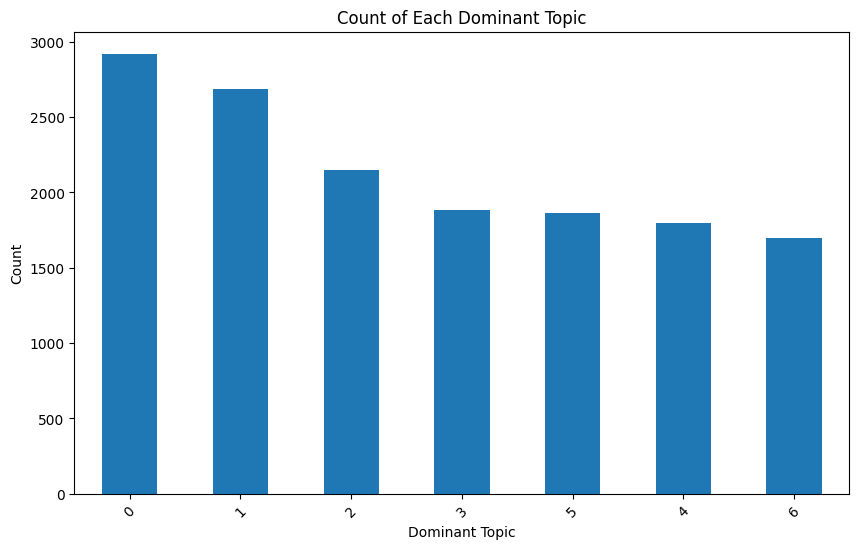

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

topic_counts = df['Dominant Topic'].value_counts()

print("Unique Values and their Counts for 'Dominant Topic':")
print(topic_counts)

plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.xlabel('Dominant Topic')
plt.ylabel('Count')
plt.title('Count of Each Dominant Topic')
plt.xticks(rotation=45)
plt.show()


In [40]:
dt = [1,2,3,4,5,6,7]
cnt = [2922, 2689, 2149, 1880,1799 ,1865 , 1696]

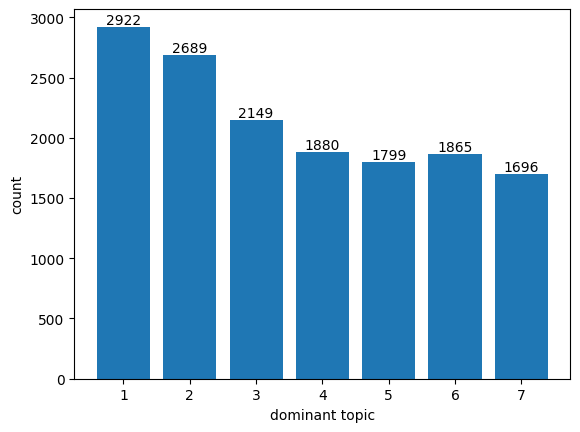

In [48]:
# Plot the bar chart
plt.bar(dt, cnt)
plt.xlabel('dominant topic')
plt.ylabel('count')

# Add values on top of each bar
for x, y in zip(dt, cnt):
    plt.text(x, y, str(y), ha='center', va='bottom')

plt.show()